# Homework 6
## https://github.com/tawest2020/taw-bios512



## Libraries

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>%
    group_by(character, episode_number) %>%
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>%
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1

#### How can we tell the character's role in the story by their plot?
The further on the x-axis away from 0 the cluster is, the more often the character appears in an episode, thus, a more central role. This is due to a consistently large count of lines per episode, an example being Picard, who rarely has a point on his plot near 0. Being further along the y-axis meanwhile serves to explain the nature of the character, whether or not their lines are quick or longwinded. Troy and Beverly are good examples, as while many times they are limited to 1-2 lines per episode, they are often a longer monologue. This could indicate their role is important or pivotal, but not central to the story.

## Question 2

In [ ]:
bev_eps <- dialogs_fixed %>%
  filter(character == "BEVERLY",
         episode_number %in% c(102:126, 149:174)) %>%
  mutate(
    season = case_when(
      episode_number %in% 102:126 ~ "Season 1",
      episode_number %in% 149:174 ~ "Season 3"
    )
  )

bev_eps_means <- bev_eps %>%
  group_by(season, episode_number) %>%
  summarize(
    mean_dialog_length = mean(dialog_length),
    dialog_count = n(),
    .groups = "drop"
  )

bev_sns_means <- bev_eps_means %>%
  group_by(season) %>%
  summarize(
    mean_of_mean_dialog_length = mean(mean_dialog_length),
    mean_dialog_count = mean(dialog_count),
    .groups = "drop"
  )

bev_sns_means


season,mean_of_mean_dialog_length,mean_dialog_count
<chr>,<dbl>,<dbl>
Season 1,56.48460,25.40
Season 3,67.04817,19.64


From season 1 to season 3, Beverly's character had less frequent lines, however more substantative. One can infer the reason her character began to feel more "male" like is due to allowing her to engage in more drawn out conversations with intellectual thought behind it instead of being a chatty character without much complexity behind the words being said.

## Question 3

In [ ]:
stopwords <- read_lines("https://gist.githubusercontent.com/sebleier/554280/raw/")

tokens <- dialogs_fixed %>%
  # Split each dialog into words
  mutate(word_list = str_split(dialog, "\\s+")) %>%

  # Unnest the list column so each word is a row
  unnest(word_list) %>%

  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%

  # Remove empty strings and stopwords
  filter(word != "", !word %in% stopwords)

head(tokens, 20)

episode_number,character,dialog,dialog_length,word_list,word
<dbl>,<chr>,<chr>,<int>,<chr>,<chr>
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,Captain's,captains
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,"log,",log
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,stardate,stardate
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,42353.7.,423537
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,destination,destination
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,planet,planet
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,Cygnus,cygnus
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,"IV,",iv
102,PICARD,"Captain's log, stardate 42353.7. Our destination is planet Cygnus IV, beyond which lies the great unexplored mass of the galaxy.",128,beyond,beyond


In [ ]:
vocab_summary <- tokens %>%
  group_by(character) %>%
  summarize(
    total_words = n(),
    unique_words = n_distinct(word),
    vocab_richness = unique_words / total_words,
    .groups = "drop"
  ) %>%
  arrange(desc(vocab_richness))

vocab_summary


character,total_words,unique_words,vocab_richness
<chr>,<int>,<int>,<dbl>
WESLEY,7601,2291,0.3014077
WORF,18820,4318,0.2294368
TROI,19450,4187,0.2152699
BEVERLY,22900,4875,0.2128821
DATA,45462,8593,0.1890150
GEORDI,31978,5465,0.1708987
RIKER,41827,6458,0.1543979
PICARD,79214,9272,0.1170500


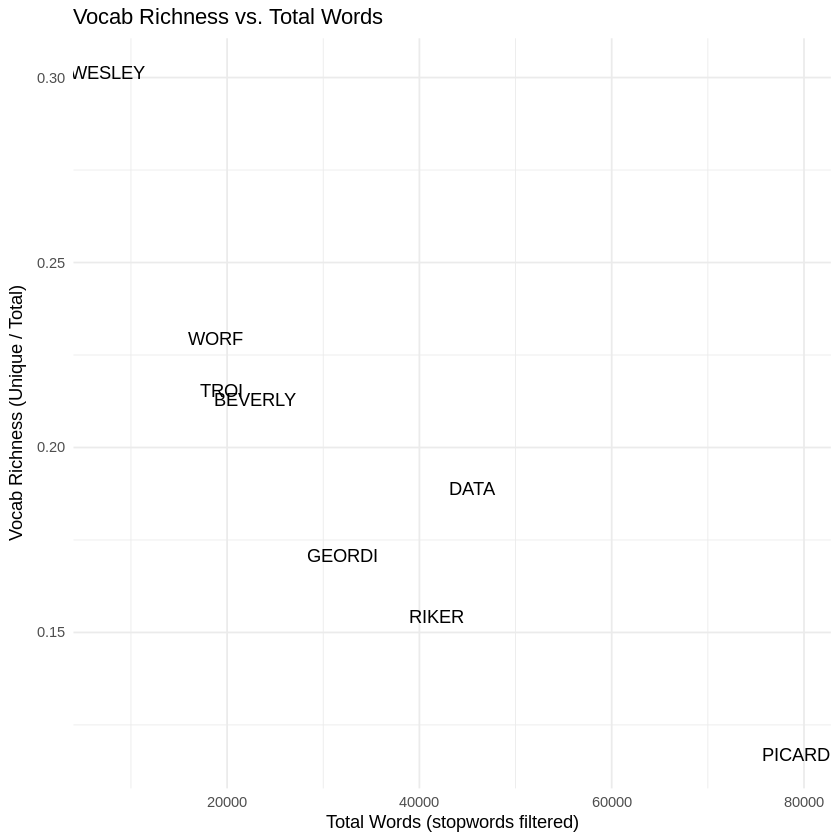

In [ ]:
ggplot(vocab_summary, aes(x = total_words, y = vocab_richness)) +
  geom_text(aes(label = character)) +
  labs(
    title = "Vocab Richness vs. Total Words",
    x = "Total Words (stopwords filtered)",
    y = "Vocab Richness (Unique / Total)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")


There is a negative linear association where as more words are spoken, the vocabulary contains less unique words, therefore losing richness. This is certainly due to the simple fact that the chance of repeating words increases as more words are spoken.

## Question 4

In [ ]:
wesley_gone <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number > 174) %>%
  count(episode_number, name = "dialog_count")

wesley_gone


episode_number,dialog_count
<dbl>,<int>
175,18
176,6
177,9
178,6
179,38
181,2
183,94
206,131
219,71


#### a) Wesley leaves the main cast in episode 183
#### b) Wesley makes cameos in episodes 206, 219, 263, and 272

#### c) Wesley's final line as a main cast member and final line of the series

In [ ]:
wesley_last_183 <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number == 183) %>%
  slice_tail(n = 1)

wesley_last_272 <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number == 272) %>%
  slice_tail(n = 1)

wesley_last_183
wesley_last_272

episode_number,character,dialog,dialog_length
<dbl>,<chr>,<chr>,<int>
183,WESLEY,I can walk.,11


episode_number,character,dialog,dialog_length
<dbl>,<chr>,<chr>,<int>
272,WESLEY,"Good-bye, Mom.",14


## Question 5

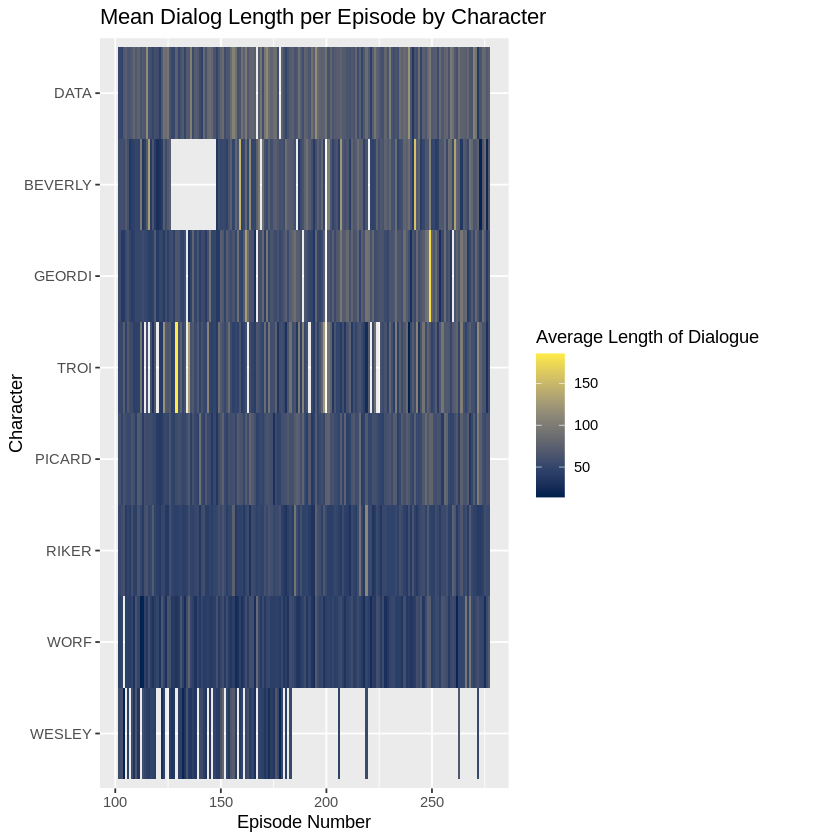

In [ ]:
cast_order <- dialog_len_per_ep %>%
  group_by(character) %>%
  summarize(overall_mean = mean(mean_dialog_length), .groups = "drop") %>%
  arrange(overall_mean) %>%
  pull(character)

cast_order_f <- dialog_len_per_ep %>%
  mutate(character = factor(character, levels = cast_order))

ggplot(cast_order_f, aes(x = episode_number, y = character, fill = mean_dialog_length)) +
  geom_tile() +
  scale_fill_viridis_c(option = "cividis") +
  labs(
    title = "Mean Dialog Length per Episode by Character",
    x = "Episode Number",
    y = "Character",
    fill = "Average Length of Dialogue"
  )